# Baseline Model for Data Scientist Salaries Classification

## Setup Packages

### Install TensorFlow

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


### Install Other Libraries

In [3]:
import datetime
from datetime import datetime

from numpy.random import RandomState
import pandas as pd
from sklearn import preprocessing


## Setup Data

### Categorize Salaries

<AxesSubplot:>

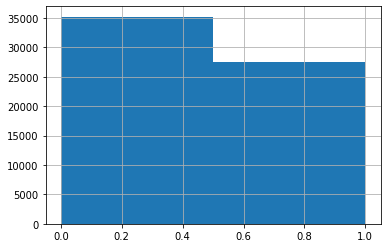

In [4]:
df = pd.read_csv('salaries.csv')

salary_ranges = [0,200000,np.inf]
df['salaryrange'] = pd.cut(df.totalyearlycompensation, salary_ranges, labels=[0,1], include_lowest=True)

df['salaryrange'].hist(bins=len(salary_ranges) - 1)

In [5]:
df.salaryrange.value_counts()

0    35213
1    27429
Name: salaryrange, dtype: int64

### Make All Values Into Integers

In [6]:
# encode timestamp into integers, by year and month
def timestamp_to_int(timestamp):
    dt_obj = datetime.strptime(timestamp.split(' ')[0], '%m/%d/%Y')
    return (100 * dt_obj.year) + (dt_obj.month)

df['timestamp'] = df['timestamp'].apply(timestamp_to_int)

# turn company names to lowercase and encode as integers
df['company'] = df['company'].apply(lambda t: str(t).lower())
df['company'] = pd.Categorical(pd.factorize(df['company'])[0])

# encode level as integer
df['level'] = pd.Categorical(pd.factorize(df['level'])[0])

# encode title as integer
df['title'] = pd.Categorical(pd.factorize(df['title'])[0])

# encode tag as integer
df['tag'] = pd.Categorical(pd.factorize(df['tag'])[0])

# encode gender as integer
df['gender'] = pd.Categorical(pd.factorize(df['gender'])[0])

# encode Race as integer
df['Race'] = pd.Categorical(pd.factorize(df['Race'])[0])

# encode Education as integer
df['Education'] = pd.Categorical(pd.factorize(df['Education'])[0])


### Remove Rows

In [7]:
df = df[df['gender'] != -1]
df = df[df['Education'] != -1]
df = df[df['Race'] != -1]

### Drop Columns

In [8]:
# make model predict without knowledge of the totalyearlycompensation
df.drop('totalyearlycompensation', axis=1, inplace=True)

# location information is already encoded as an integer in 'cityid'
df.drop('location', axis=1, inplace=True)

# make model predict without knowledge of the base salary, stock grant value, or bonus
df.drop('basesalary', axis=1, inplace=True)

# 'otherdetails' column requires NLP to interpret
df.drop('otherdetails', axis=1, inplace=True)

# 'rowNumber' column is unnecessary
df.drop('rowNumber', axis=1, inplace=True)

# education information is entirely encoded in the 'Education' column already
df.drop('Masters_Degree', axis=1, inplace=True)
df.drop('Bachelors_Degree', axis=1, inplace=True)
df.drop('Doctorate_Degree', axis=1, inplace=True)
df.drop('Highschool', axis=1, inplace=True)
df.drop('Some_College', axis=1, inplace=True)

# race information is entirely encoded in the 'Race' column already
df.drop('Race_Asian', axis=1, inplace=True)
df.drop('Race_White', axis=1, inplace=True)
df.drop('Race_Two_Or_More', axis=1, inplace=True)
df.drop('Race_Black', axis=1, inplace=True)
df.drop('Race_Hispanic', axis=1, inplace=True)

### Training/Testing Data

In [9]:
drop_indices = np.random.choice(df.index, len(df.index) % 1250, replace=False)
df.drop(drop_indices, inplace=True)

rng = RandomState()

df_train = df.sample(frac=0.8, random_state=rng)
df_test = df.loc[~df.index.isin(df_train.index)]

In [10]:
train_data = df_train.loc[:, df_train.columns != 'salaryrange'].to_numpy()
test_data = df_test.loc[:, df_test.columns != 'salaryrange'].to_numpy()

train_labels = df_train['salaryrange'].to_numpy()
test_labels = df_test['salaryrange'].to_numpy()

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(salary_ranges) - 1)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(salary_ranges) - 1)

## Make the Model

### Set Variables

In [11]:
epochs = 7
batch_size = 25

### Add Layers to Model

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(len(salary_ranges) - 1, activation='softmax')
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), loss='mse', metrics=['accuracy'])
model.build(train_data.shape)
model.summary()
model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  960       
                                                                 
 dense_1 (Dense)             multiple                  2080      
                                                                 
 dense_2 (Dense)             multiple                  66        
                                                                 
Total params: 3,106
Trainable params: 3,106
Non-trainable params: 0
_________________________________________________________________
Train on 17000 samples, validate on 4250 samples
Epoch 1/7
 2100/17000 [==>...........................] - ETA: 0s - loss: 0.3345 - acc: 0.3914 

2022-05-10 15:45:13.979520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


17000/17000 [==============================] - 1s 31us/sample - loss: 0.2434 - acc: 0.5858 - val_loss: 0.2092 - val_acc: 0.6591
Epoch 2/7
 4475/17000 [======>.......................] - ETA: 0s - loss: 0.2086 - acc: 0.6664

/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


17000/17000 [==============================] - 0s 26us/sample - loss: 0.2024 - acc: 0.6786 - val_loss: 0.1958 - val_acc: 0.7139
Epoch 3/7
17000/17000 [==============================] - 0s 26us/sample - loss: 0.1899 - acc: 0.7169 - val_loss: 0.1830 - val_acc: 0.7355
Epoch 4/7
17000/17000 [==============================] - 0s 26us/sample - loss: 0.1770 - acc: 0.7542 - val_loss: 0.1701 - val_acc: 0.7614
Epoch 5/7
17000/17000 [==============================] - 0s 26us/sample - loss: 0.1655 - acc: 0.8028 - val_loss: 0.1578 - val_acc: 0.8207
Epoch 6/7
17000/17000 [==============================] - 0s 26us/sample - loss: 0.1520 - acc: 0.8231 - val_loss: 0.1455 - val_acc: 0.8320
Epoch 7/7
17000/17000 [==============================] - 0s 26us/sample - loss: 0.1411 - acc: 0.8363 - val_loss: 0.1352 - val_acc: 0.8431


In [14]:
model_loss, model_metric = model.evaluate(test_data, test_labels, batch_size=batch_size)
print(model_metric)

0.8430588
